# GoodReads Data Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import datetime
from datetime import date

import warnings
warnings.filterwarnings("ignore") #comment this out if there are unexpected errors below

In [2]:
raw = pd.read_csv('ReadingHistory.csv')

## Cleaning & Tidying

Checklist
 - Drop duplicates
 - Drop unread books
 - Convert "My Rating" column into integer on a scale of 1 to 5
 - Convert all Date strings to DateTime values
 
Note on Dates in Pandas (from StackOverflow):

Since pandas represents timestamps in nanosecond resolution, the timespan that can be represented using a 64-bit integer is limited to approximately 584 years. The earliest time stamp that can be represented as of this writing is 1677. So, writings by Plato or Shakespear, to name a few, will be eliminated from the dataset. 

In [12]:
duplicates = raw.groupby(raw.Title.tolist(),as_index=False).size().sort_values('size', ascending=False)
duplicates[duplicates['size'] >= 2].count()

In [ ]:
raw = raw.drop_duplicates(subset=['Title'], keep="first")

In [13]:
# credit: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction. 
def missing_values_table(df):
        mis_val = df.isnull().sum() #Total missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df) #Percentage of missing values
        dtype = df.dtypes #Column for dtypes
        mis_val_table = pd.concat([mis_val, mis_val_percent,dtype], axis=1) #Make a table with the results
        
        #Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values', 2:'Data Types'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

In [14]:
missing_values_table(raw)

Your selected dataframe has 15 columns.
There are 4 columns that have missing values.


,Missing Values,% of Total Values,Data Types
My Rating,114,16.7,object
ISBN,72,10.6,object
IBSN13,67,9.8,float64
Number of Pages,9,1.3,float64


In [189]:
all_books = raw['Title'].count()
books_read = raw.dropna(subset=['My Rating'])
books_read_count = books_read['Title'].count()
books_unread = raw[raw['Read Count'] == 0]
books_unread_count = books_unread['Title'].count()

In [190]:
#Translate "My Rating" column into integers
def label_rating_integer (row):
   if row['My Rating'] == 'did not like it' :
      return 1
   if row['My Rating'] == 'it was ok' :
      return 2
   if row['My Rating'] == 'liked it' :
      return 3
   if row['My Rating']  == 'really liked it' :
      return 4
   if row['My Rating'] == 'it was amazing' :
      return 5
    
books_read['My Rating (int)'] = books_read.apply(lambda row: label_rating_integer(row), axis=1)

In [191]:
def guess_date(string):
    for format_style in ['%b %d, %Y', '%b %d %Y', '%b %Y', '%Y']:
        #Cells with only a year will autofill to the the first day of the first month of that year
        #Cells with only a month and year will autofill to the first day of that month
        #Cells with "Unknown" will autofill to "None"
        try:
            return datetime.datetime.strptime(string, format_style).date()
        except ValueError:
            continue
#    raise ValueError(string)

In [192]:
books_read['Publish Date'] = books_read['Publish Date'].apply(lambda x: guess_date(x))
books_read['Publish Date Edition'] = books_read['Publish Date Edition'].apply(lambda x: guess_date(x))
books_read['Date Started'] = books_read['Date Started'].apply(lambda x: guess_date(x))
books_read['Date Read'] = books_read['Date Read'].apply(lambda x: guess_date(x))
books_read['Date Added'] = books_read['Date Added'].apply(lambda x: guess_date(x))

In [193]:
books_read['Publish Date'] = pd.to_datetime(books_read['Publish Date'], errors='coerce')
books_read['Publish Date Edition'] = pd.to_datetime(books_read['Publish Date Edition'], errors='coerce')
books_read['Date Started'] = pd.to_datetime(books_read['Date Started'], errors='coerce')
books_read['Date Read'] = pd.to_datetime(books_read['Date Read'], errors='coerce')
books_read['Date Added'] = pd.to_datetime(books_read['Date Added'], errors='coerce')

In [194]:
books_read['Reading Time (Days)'] = books_read['Date Read'] - books_read['Date Started']
books_read['Reading Time (Days)'] = books_read['Reading Time (Days)'].dt.days

In [195]:
print("There are {} books in your GoodReads account".format(all_books))
print("There are {} read books".format(books_read_count))
print("There are {} unread books".format(books_unread_count))

print('Most recent addition:')
print('')
# print(books_read['Date Read'].max())
print(books_read.loc[books_read['Date Read'].idxmax()])

There are 680 books in your GoodReads account
There are 567 read books
There are 82 unread books
Most recent addition:

Title                   An Ugly Truth: Inside Facebook's Battle for Do...
Author                                                    Frenkel, Sheera
ISBN                                                           0062960679
IBSN13                                                    9780062960672.0
Number of Pages                                                     400.0
Average Rating                                                       4.15
Number of Ratings                                                     134
Publish Date                                          2021-07-13 00:00:00
Publish Date Edition                                  2020-08-25 00:00:00
My Rating                                                 really liked it
Shelves                                                      1 of 5 stars
Read Count                                                        

In [196]:
books_read.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 567 entries, 1 to 712
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Title                 567 non-null    object        
 1   Author                567 non-null    object        
 2   ISBN                  514 non-null    object        
 3   IBSN13                517 non-null    float64       
 4   Number of Pages       559 non-null    float64       
 5   Average Rating        567 non-null    float64       
 6   Number of Ratings     567 non-null    int64         
 7   Publish Date          547 non-null    datetime64[ns]
 8   Publish Date Edition  563 non-null    datetime64[ns]
 9   My Rating             567 non-null    object        
 10  Shelves               567 non-null    object        
 11  Read Count            567 non-null    int64         
 12  Date Started          83 non-null     datetime64[ns]
 13  Date Read           

In [197]:
books_read.isnull().sum()

Title                     0
Author                    0
ISBN                     53
IBSN13                   50
Number of Pages           8
Average Rating            0
Number of Ratings         0
Publish Date             20
Publish Date Edition      4
My Rating                 0
Shelves                   0
Read Count                0
Date Started            484
Date Read               126
Date Added                0
My Rating (int)           0
Reading Time (Days)     484
dtype: int64

## Page Analysis

In [198]:
pages = raw['Number of Pages']
no_pages = pages.isnull().sum()
pages = pages.dropna()
books_with_page_counts = pages.count()

print('Books without page counts listed on Goodreads: {}'.format(no_pages))
print('Books that can be analyzed: {}'.format(books_with_page_counts))

Books without page counts listed on Goodreads: 9
Books that can be analyzed: 671


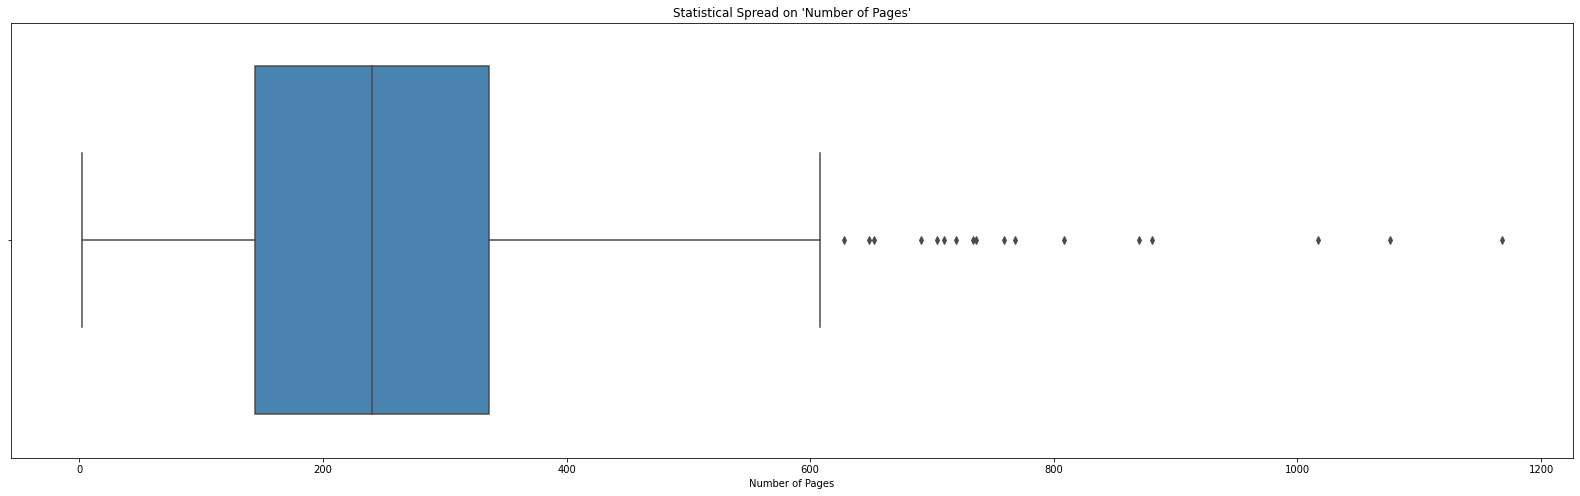

Mean: 262.0
Median: 240.0
Max: 1168.0; Title: ['Guardians of the Galaxy by Brian Michael Bendis Omnibus, Vol. 1']
Min: 2.0; Title: ['A Perfect Time for Pandas (Magic Tree House, #48)']


In [199]:
fig, ax = plt.subplots(figsize=(28,8))
sns.boxplot(x=pages, palette='Blues_d').set_title("Statistical Spread on 'Number of Pages'")
plt.show()

pages_mean = round(raw['Number of Pages'].mean(), 0)
pages_median = round(raw['Number of Pages'].median(), 0)
pages_max = round(raw['Number of Pages'].max(), 0)
book_max = raw.loc[raw['Number of Pages'] == pages_max]
pages_min = round(raw['Number of Pages'].min(), 0)
book_min = raw.loc[raw['Number of Pages'] == pages_min]

print('Mean: {}'.format(pages_mean))
print('Median: {}'.format(pages_median))
print('Max: {}; Title: {}'.format(pages_max, book_max['Title'].values))
print('Min: {}; Title: {}'.format(pages_min, book_min['Title'].values))

### Authors

Checklist:
 - Most Read Authors
 - Most Read Authors by Books Read
 - Most Read Authors by Pages Read
 - Most Read Authors factoring in Read Count

In [200]:
author_read_counts = books_read['Author'].value_counts().rename_axis('Author').reset_index(name='Counts')
author_read_counts = author_read_counts[author_read_counts['Counts'] > 1]
print("The number of authors you have read twice or more: {}".format(author_read_counts['Author'].count()))

The number of authors you have read twice or more: 77


In [201]:
authors = books_read['Author'].value_counts()
authors_dataframe = pd.DataFrame({'Author': authors.index, 'Books Read': authors.values})
authors_top20 = authors_dataframe[:20]
print('Top 20 Most Read Authors')
print('')
authors_top20

Top 20 Most Read Authors



,Author,Books Read
0,"Bendis, Brian Michael",52
1,"Osborne, Mary Pope",50
2,"King, Tom",14
3,"Snyder, Scott",12
4,"Horowitz, Anthony",10
5,"Johns, Geoff",10
6,"Soule, Charles",9
7,"Rowling, J.K.",8
8,"Spencer, Nick",8
9,"Riordan, Rick",8


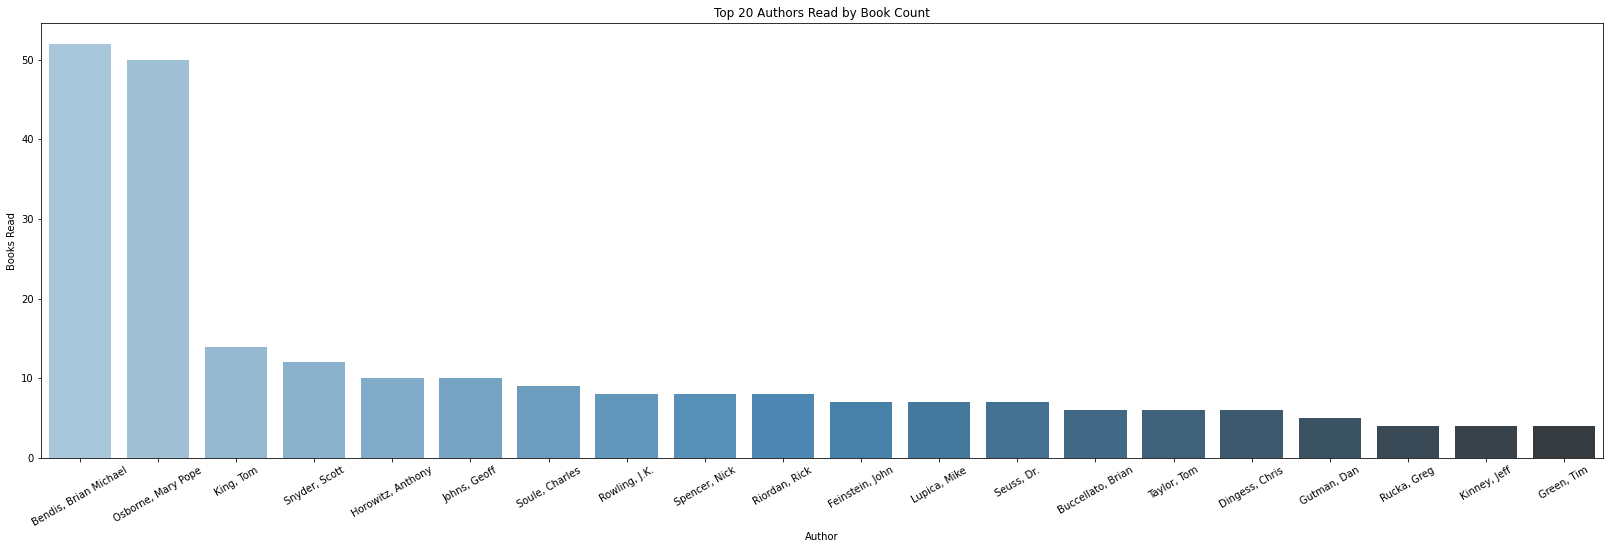

In [202]:
fig, ax = plt.subplots(figsize=(28,8))
plot = sns.barplot(x=authors_top20['Author'], y=authors_top20['Books Read'], palette='Blues_d')
ax.set_title('Top 20 Authors Read by Book Count')
plt.setp(plot.get_xticklabels(), rotation=30)
plt.show()

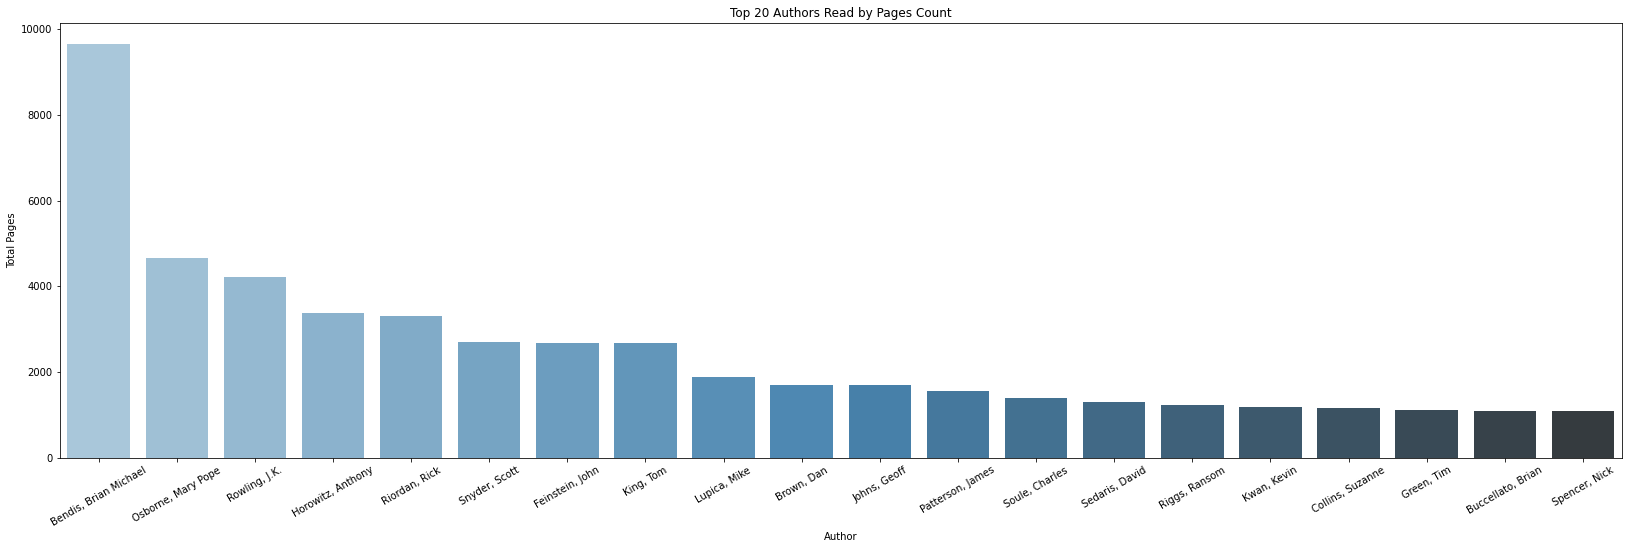

In [203]:
author_groupings = books_read.groupby('Author')
authors_pages = author_groupings['Number of Pages'].sum()
authors_pages_df = pd.DataFrame({'Author': authors_pages.index, 'Total Pages': authors_pages.values})
authors_pages_df_sorted = authors_pages_df.sort_values(by=['Total Pages'], ascending=False)
authors_pages_df_sorted_top20 = authors_pages_df_sorted[:20]

fig, ax = plt.subplots(figsize=(28,8))
plot = sns.barplot(x=authors_pages_df_sorted_top20['Author'], y=authors_pages_df_sorted_top20['Total Pages'], palette='Blues_d')
ax.set_title('Top 20 Authors Read by Pages Count')
plt.setp(plot.get_xticklabels(), rotation=30)
plt.show()

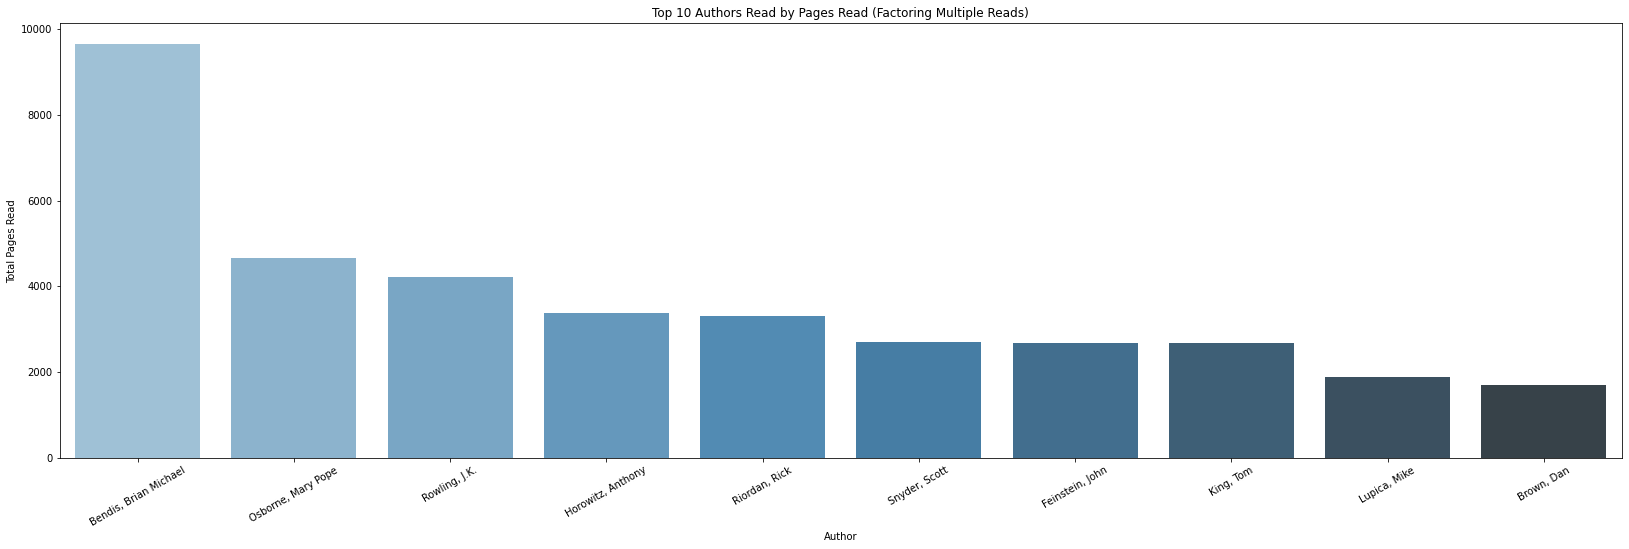

In [204]:
authors_df = books_read[['Title', 'Author', 'Number of Pages', 'Read Count']]
authors_df['Total Pages Read'] = authors_df['Number of Pages'] * authors_df['Read Count']
author_groupings = authors_df.groupby('Author')
author_tps = author_groupings['Total Pages Read'].sum()
author_tps_df = pd.DataFrame({'Author': author_tps.index, 'Total Pages Read': author_tps.values})
author_tps_df_sorted = author_tps_df.sort_values(by='Total Pages Read', ascending=False)
author_tps_df_sorted_top10 = author_tps_df_sorted[:10]

fig, ax = plt.subplots(figsize=(28,8))
plot = sns.barplot(x=author_tps_df_sorted_top10['Author'], y=author_tps_df_sorted_top10['Total Pages Read'], palette='Blues_d')
ax.set_title('Top 10 Authors Read by Pages Read (Factoring Multiple Reads)')
plt.setp(plot.get_xticklabels(), rotation=30)
plt.show()

## Ratings Analysis

Checklist
 - Statistical Spread on 'Numbers of Pages'
 - Statistical Spread on 'Numbers of Pages' adjusted for outliers

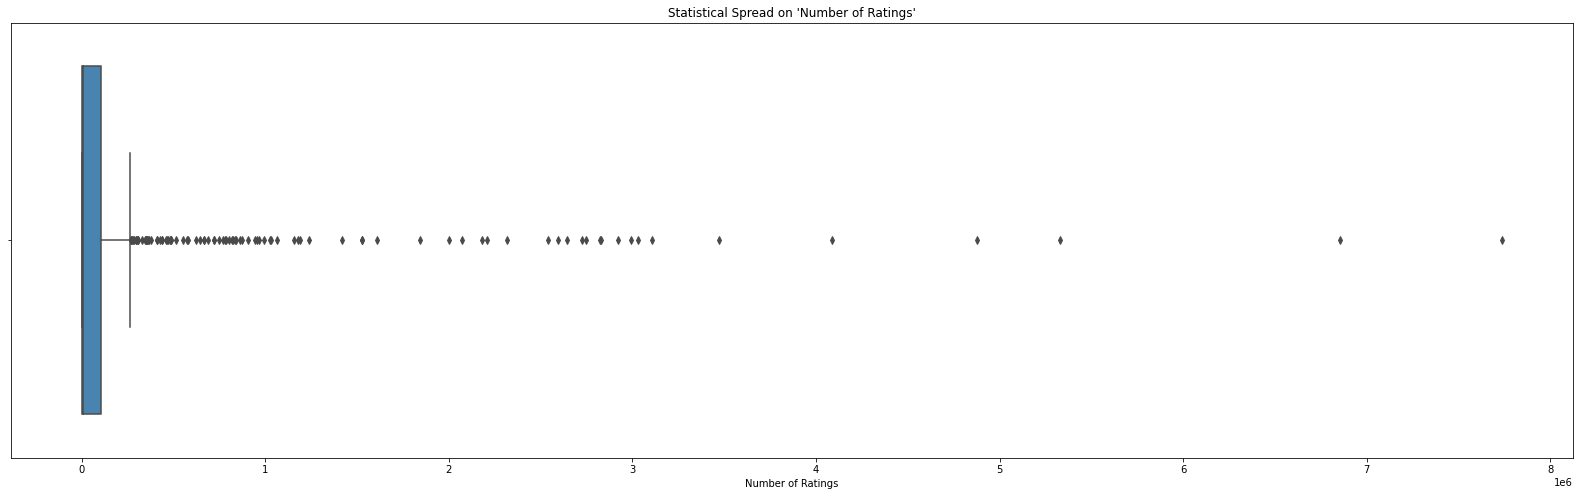

Mean: 237571.0
Median: 7670.0
Max: 7737928; Title: ["Harry Potter and the Sorcerer's Stone (Harry Potter, #1)"]
Min: 1; Title: ['American Made']


In [205]:
fig, ax = plt.subplots(figsize=(28,8))
sns.boxplot(x=books_read['Number of Ratings'], palette='Blues_d').set_title("Statistical Spread on 'Number of Ratings'")
plt.show()

ratings_mean = round(books_read['Number of Ratings'].mean(), 0)
ratings_median = round(books_read['Number of Ratings'].median(), 0)
ratings_max = round(books_read['Number of Ratings'].max(), 0)
book_max = books_read.loc[books_read['Number of Ratings'] == ratings_max]
ratings_min = round(books_read['Number of Ratings'].min(), 0)
book_min = books_read.loc[books_read['Number of Ratings'] == ratings_min]

print('Mean: {}'.format(ratings_mean))
print('Median: {}'.format(ratings_median))
print('Max: {}; Title: {}'.format(ratings_max, book_max['Title'].values))
print('Min: {}; Title: {}'.format(ratings_min, book_min['Title'].values))

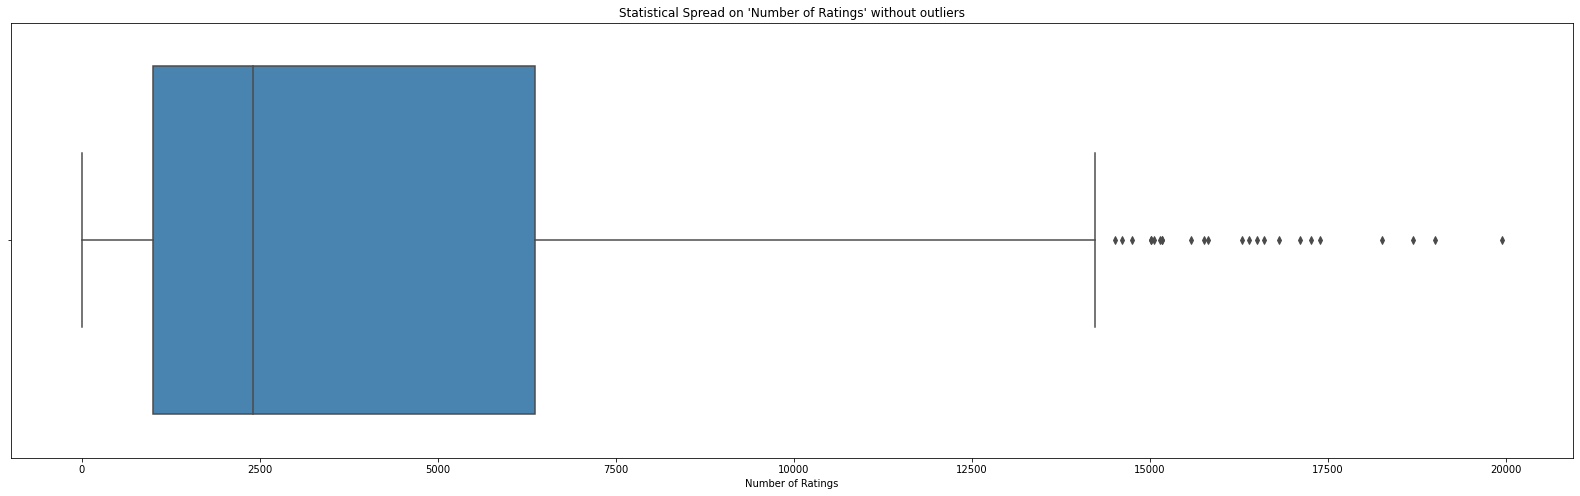

Mean: 4364.0
Median: 2405.0
Max: 19944; Title: ['Strange Weather in Tokyo']
Min: 1; Title: ['American Made']


In [206]:
ratings_no_outliers = books_read[books_read['Number of Ratings'] <= 20000]

fig, ax = plt.subplots(figsize=(28,8))
sns.boxplot(x=ratings_no_outliers['Number of Ratings'], palette='Blues_d').set_title("Statistical Spread on 'Number of Ratings' without outliers")
plt.show()

ratings_mean = round(ratings_no_outliers['Number of Ratings'].mean(), 0)
ratings_median = round(ratings_no_outliers['Number of Ratings'].median(), 0)
ratings_max = round(ratings_no_outliers['Number of Ratings'].max(), 0)
book_max = ratings_no_outliers.loc[ratings_no_outliers['Number of Ratings'] == ratings_max]
ratings_min = round(ratings_no_outliers['Number of Ratings'].min(), 0)
book_min = ratings_no_outliers.loc[ratings_no_outliers['Number of Ratings'] == ratings_min]

print('Mean: {}'.format(ratings_mean))
print('Median: {}'.format(ratings_median))
print('Max: {}; Title: {}'.format(ratings_max, book_max['Title'].values))
print('Min: {}; Title: {}'.format(ratings_min, book_min['Title'].values))

Text(0.5, 1.0, 'Most Rated Books on GoodReads in your Reading History')

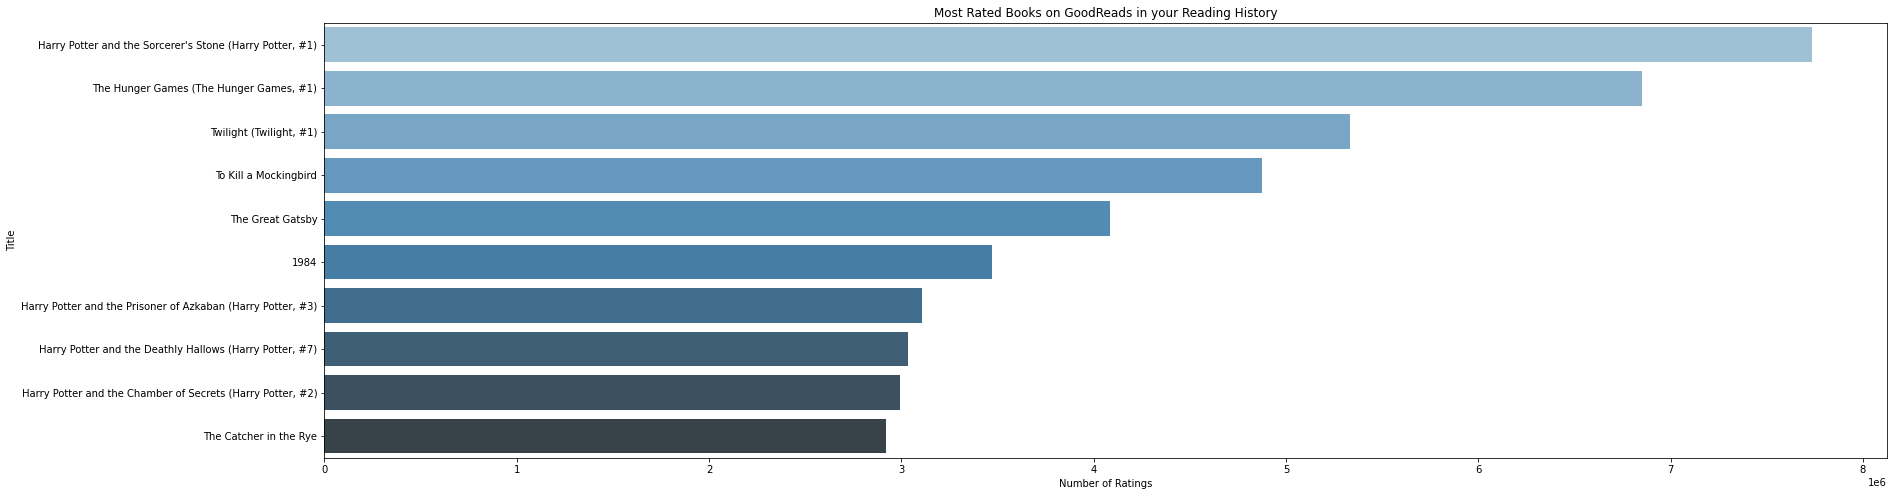

In [207]:
most_rated = books_read.sort_values('Number of Ratings', ascending = False).head(10).set_index('Title')
plt.figure(figsize=(28,8))
sns.barplot(most_rated['Number of Ratings'], most_rated.index, palette='Blues_d').set_title("Most Rated Books on GoodReads in your Reading History")

## Dates & Reading Time

Checklist
 - Longest Reads by Days Spent Reading
 - Books with Most Pages Read per Day
 - Books with Least Pages Read per Day

In [208]:
reading_time_df = books_read[books_read['Reading Time (Days)'].notnull()]

Text(0.5, 1.0, 'Longest Reads by Day Spent Reading')

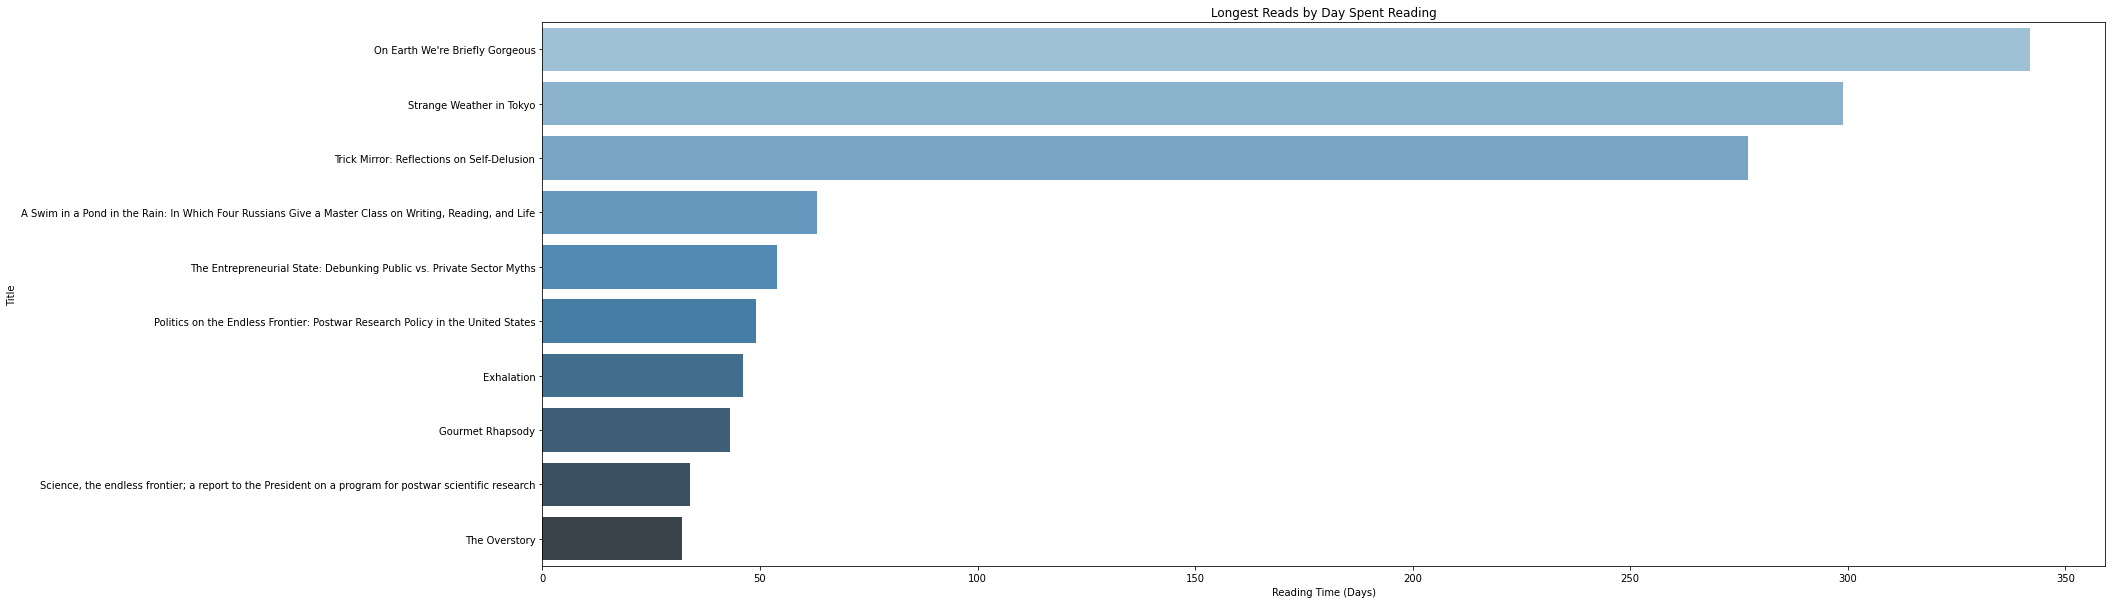

In [209]:
longest_reads = reading_time_df.sort_values(by='Reading Time (Days)', ascending=False).head(10).set_index('Title')
plt.figure(figsize=(28,10))
sns.barplot(longest_reads['Reading Time (Days)'], longest_reads.index, palette='Blues_d').set_title("Longest Reads by Day Spent Reading")

In [210]:
reading_time_df['Pages/Day'] = round(reading_time_df['Number of Pages'] / reading_time_df['Reading Time (Days)'], 2)
reading_time_df['Pages/Day'].replace([np.inf, -np.inf], np.nan, inplace=True)
reading_time_df['Pages/Day'].fillna(reading_time_df['Number of Pages'], inplace=True)

Text(0.5, 1.0, 'Books with Most Pages Read per Day')

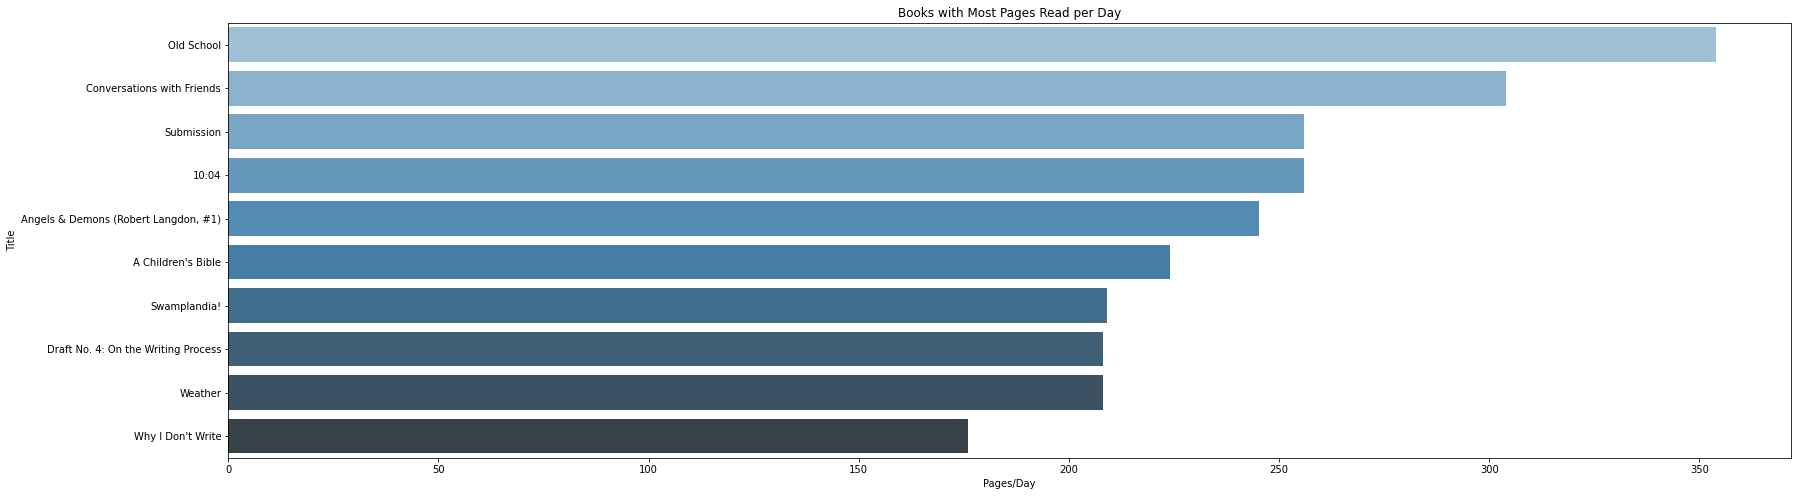

In [211]:
most_pages_read_daily = reading_time_df.sort_values(by='Pages/Day', ascending=False).head(10).set_index('Title')
fig, ax = plt.subplots(figsize=(28,8))
sns.barplot(most_pages_read_daily['Pages/Day'], most_pages_read_daily.index, palette='Blues_d').set_title("Books with Most Pages Read per Day")

Text(0.5, 1.0, 'Books with Least Pages Read per Day')

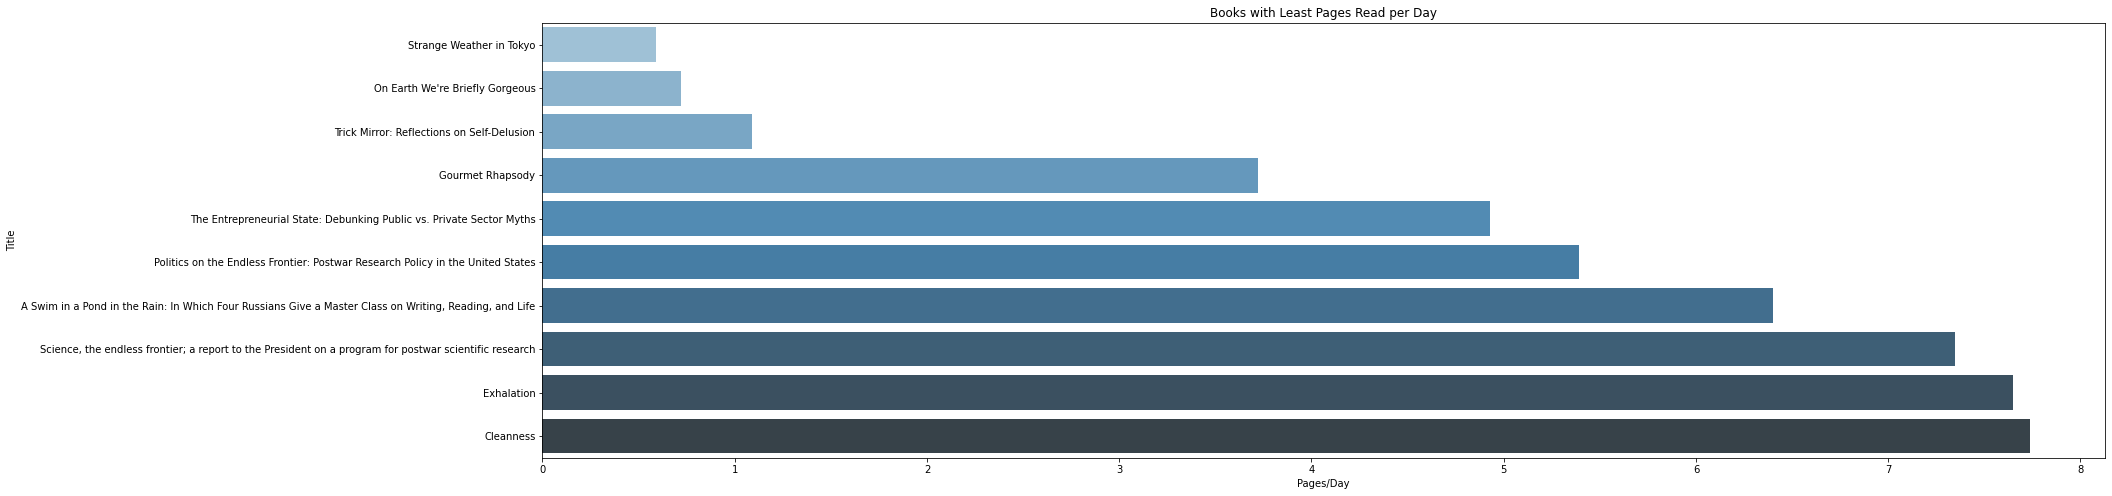

In [212]:
least_pages_read_daily = reading_time_df.sort_values(by='Pages/Day', ascending=True).head(10).set_index('Title')
fig, ax = plt.subplots(figsize=(28,8))
sns.barplot(least_pages_read_daily['Pages/Day'], least_pages_read_daily.index, palette='Blues_d').set_title("Books with Least Pages Read per Day")

## Year in Reading

This section examines the last 365 days of your reading history.

Checklist:

- Book Count
- Ratings Visualization
- 5 Star Read Display
- 1 Star Read Display
- Pages Read in Recent Year versus Previous Years (Mean, Median, Max, Min)
- Average reading time for Recent Year v. Average reading time of Previous Years

In [213]:
one_year_ago = datetime.datetime.now() - datetime.timedelta(days=1*365)
recent_year = books_read[books_read['Date Read'] >= one_year_ago]
previous_years = books_read[books_read['Date Read'] <= one_year_ago] #will be used later for comparisons
print("Books Read in last 365 days: {}".format(recent_year['Title'].count()))

Books Read in last 365 days: 48


You rated 10 books at 5 Stars
You rated 21 books at 4 Stars
You rated 13 books at 3 Stars
You rated 4 books at 2 Stars
You rated 0 books at 1 Stars


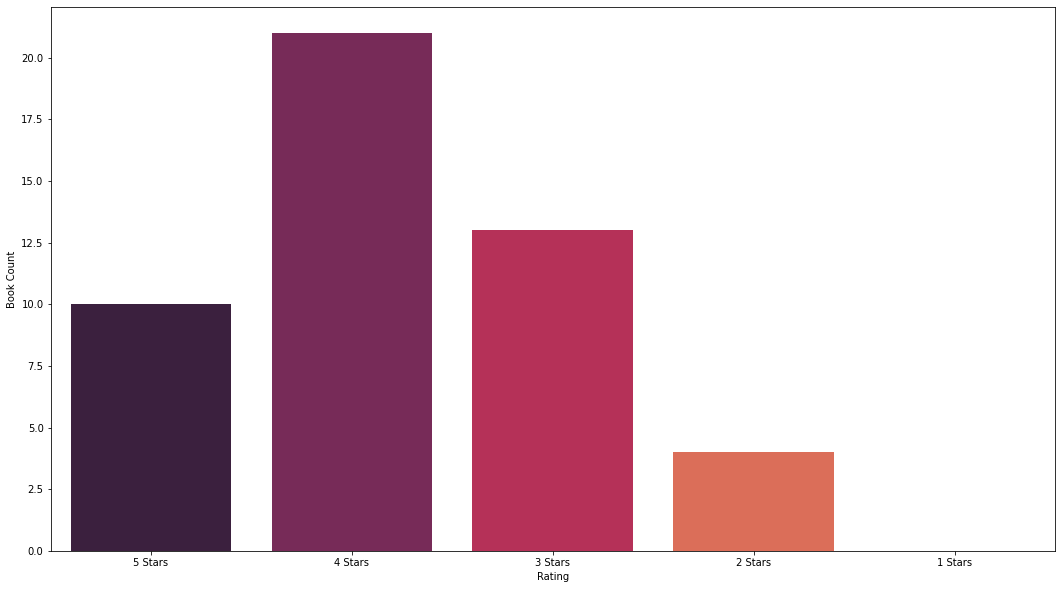

In [214]:
five_star_reads = recent_year[recent_year['My Rating (int)'] == 5]
four_star_reads = recent_year[recent_year['My Rating (int)'] == 4]
three_star_reads = recent_year[recent_year['My Rating (int)'] == 3]
two_star_reads = recent_year[recent_year['My Rating (int)'] == 2]
one_star_reads = recent_year[recent_year['My Rating (int)'] == 1]

fives = int(five_star_reads['Title'].count())
fours = int(four_star_reads['Title'].count())
threes = int(three_star_reads['Title'].count())
twos = int(two_star_reads['Title'].count())
ones = int(one_star_reads['Title'].count())

print("You rated {} books at 5 Stars".format(fives))
print("You rated {} books at 4 Stars".format(fours))
print("You rated {} books at 3 Stars".format(threes))
print("You rated {} books at 2 Stars".format(twos))
print("You rated {} books at 1 Stars".format(ones))

recent_year_ratings = pd.DataFrame({
    'Rating': ['5 Stars', '4 Stars', '3 Stars', '2 Stars', '1 Stars'],
    'Book Count': [fives, fours, threes, twos, ones]
})

bar, ax = plt.subplots(figsize=[18,10])
ax = sns.barplot(x=recent_year_ratings.Rating, y=recent_year_ratings['Book Count'], palette='rocket')

In [215]:
five_star_reads

,Title,Author,ISBN,IBSN13,Number of Pages,Average Rating,Number of Ratings,Publish Date,Publish Date Edition,My Rating,Shelves,Read Count,Date Started,Date Read,Date Added,My Rating (int),Reading Time (Days)
9,What Belongs to You,"Greenwell, Garth",0374288224,9.780374e+12,195.0,3.77,10921,2016-01-19,2016-01-19,it was amazing,1 of 5 stars,1,2021-07-05,2021-07-07,2021-06-24,5,2.0
17,Too Loud a Solitude,"Hrabal, Bohumil",0349102627,9.780349e+12,98.0,4.04,17112,1976-01-01,2007-08-01,it was amazing,1 of 5 stars,1,2021-05-28,2021-05-29,2021-05-28,5,1.0
19,Old School,"Wolff, Tobias",NaN,NaN,354.0,3.83,11599,2003-01-01,2004-08-31,it was amazing,1 of 5 stars,1,2021-05-29,2021-05-30,2021-05-28,5,1.0
61,Interpreter of Maladies,"Lahiri, Jhumpa",0618101365,9.780618e+12,198.0,4.16,167793,1999-04-20,2000-05-22,it was amazing,1 of 5 stars,1,2021-05-08,2021-05-12,2021-04-19,5,4.0
64,The Entrepreneurial State: Debunking Public vs...,"Mazzucato, Mariana",0857282514,9.780857e+12,266.0,3.97,1984,2011-01-01,2013-06-10,it was amazing,1 of 5 stars,1,2021-01-21,2021-03-16,2021-03-24,5,54.0
86,A Children's Bible,"Millet, Lydia",1324005033,9.781324e+12,224.0,3.75,20189,2020-05-12,2020-05-12,it was amazing,1 of 5 stars,1,2020-12-07,2020-12-08,2020-12-07,5,1.0
95,The Only Story,"Barnes, Julian",1473554799,9.781474e+12,272.0,3.61,18698,2018-02-01,2018-02-01,it was amazing,1 of 5 stars,1,2020-11-05,2020-11-12,2020-11-05,5,7.0
98,The Sense of an Ending,"Barnes, Julian",0224094157,9.780224e+12,150.0,3.73,159876,2011-08-04,2011-08-04,it was amazing,1 of 5 stars,1,2020-10-24,2020-10-25,2020-10-24,5,1.0
216,The Kite Runner,"Hosseini, Khaled",NaN,NaN,371.0,4.31,2595423,2003-05-29,2004-05-01,it was amazing,1 of 5 stars,1,2020-10-30,2020-11-02,2019-06-12,5,3.0
284,The Underground Railroad,"Whitehead, Colson",0385542364,9.780386e+12,306.0,4.04,328834,2016-08-02,2016-08-02,it was amazing,1 of 5 stars,1,2020-08-25,2020-09-01,2018-07-23,5,7.0


In [216]:
one_star_reads

,Title,Author,ISBN,IBSN13,Number of Pages,Average Rating,Number of Ratings,Publish Date,Publish Date Edition,My Rating,Shelves,Read Count,Date Started,Date Read,Date Added,My Rating (int),Reading Time (Days)


In [217]:
average_pages_ry = recent_year['Number of Pages'].mean()
print(average_pages_ry)
median_pages_ry = recent_year['Number of Pages'].median()
print(median_pages_ry)
maximum_pages_ry = recent_year['Number of Pages'].max()
print(maximum_pages_ry)
minimum_pages_ry = recent_year['Number of Pages'].min()
print(minimum_pages_ry)

264.1063829787234
267.0
450.0
80.0


In [218]:
average_pages_py = previous_years['Number of Pages'].mean()
print(average_pages_py)
median_pages_py = previous_years['Number of Pages'].median()
print(median_pages_py)

maximum_pages_py = previous_years['Number of Pages'].max()
print(maximum_pages_py)
minimum_pages_py = previous_years['Number of Pages'].min()
print(minimum_pages_py)

260.7113402061856
226.5
1076.0
26.0


In [219]:
while True:
    print("Comparing your previous year's reading against prior years: ")
    print("---")
    
    #Average
    if average_pages_ry > average_pages_py:
        difference = round(average_pages_ry - average_pages_py, 2)
        print("You read an average of {} pages more per book than previous years".format(difference))
    else:
        difference = round(average_pages_py - average_pages_ry, 2)
        print("You read an average of {} pages less per book than previous years".format(difference))
        
    #Median
    if median_pages_ry > median_pages_py:
        difference = round(median_pages_ry - median_pages_py, 2)
        print("You read a median of {} pages more per book than previous years".format(difference))
    else:
        difference = round(median_pages_py - median_pages_ry, 2)
        print("You read a median of {} pages less per book than previous years".format(difference))
        
    #Max
    if maximum_pages_ry > maximum_pages_py:
        difference = round(maximum_pages_ry - maximum_pages_py, 2)
        print("Your longest read was {} pages more than your longest read in your reading history".format(difference))
    else:
        difference = round(maximum_pages_py - maximum_pages_ry, 2)
        print("Your longest read was {} pages less than your longest read in your reading history".format(difference))
        
    #Min
    if minimum_pages_ry > minimum_pages_py:
        difference = round(minimum_pages_ry - minimum_pages_py, 2)
        print("Your shortest read was {} pages more than your shortest read in your reading history".format(difference))
    else:
        difference = round(minimum_pages_py - minimum_pages_ry, 2)
        print("Your shortest read was {} pages less than your shortest read in your reading history".format(difference))

    break

Comparing your previous year's reading against prior years: 
---
You read an average of 3.4 pages more per book than previous years
You read a median of 40.5 pages more per book than previous years
Your longest read was 626.0 pages less than your longest read in your reading history
Your shortest read was 54.0 pages more than your shortest read in your reading history


## Books Read by Year

In [316]:
books_read['Year Read'] = books_read['Date Read'].dt.year

In [221]:
year_read_groupings = books_read.groupby(['Year Read']).size()
year_read_df = pd.DataFrame({'Year Read': year_read_groupings.index, 'Count': year_read_groupings.values})

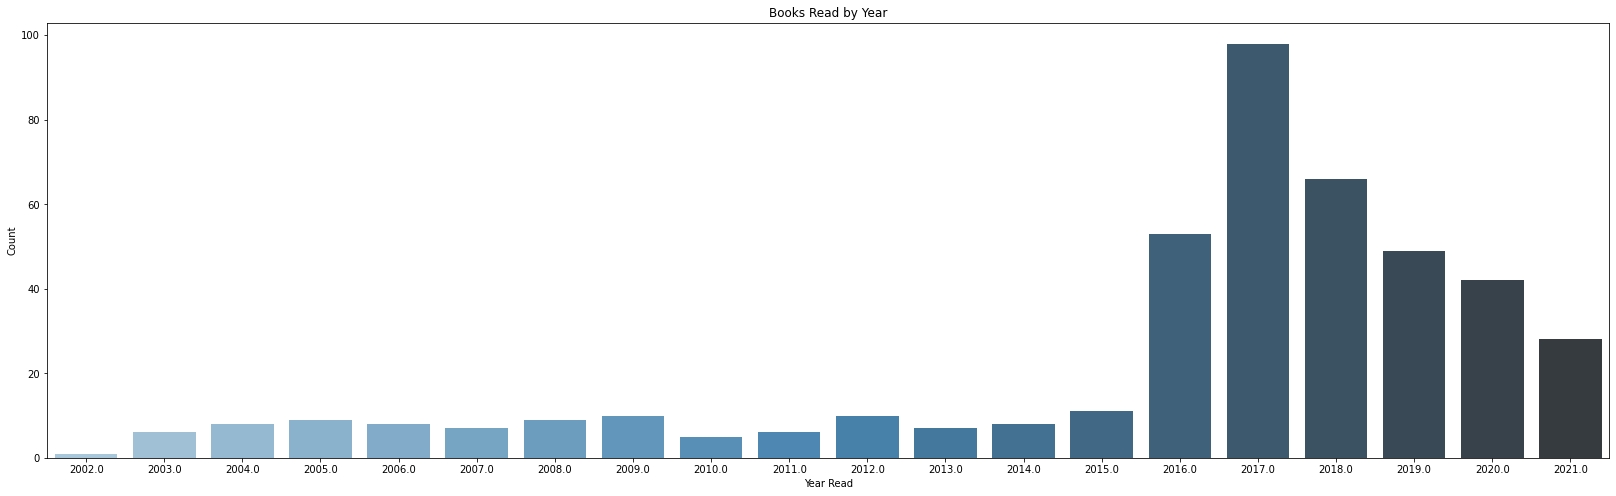

In [222]:
fig, ax = plt.subplots(figsize=(28,8))
plot = sns.barplot(x=year_read_df['Year Read'], y=year_read_df['Count'], palette='Blues_d')
ax.set_title('Books Read by Year')
plt.show()

In [223]:
groupings = books_read.groupby(['Year Read'])
pages_mean = round(groupings['Number of Pages'].mean(),2)
pages_mean_df = pd.DataFrame({'Year Read': pages_mean.index, 'Average Pages': pages_mean.values})
pages_median = round(groupings['Number of Pages'].median(),2)
pages_median_df = pd.DataFrame({'Year Read': pages_median.index, 'Median Pages': pages_median.values})

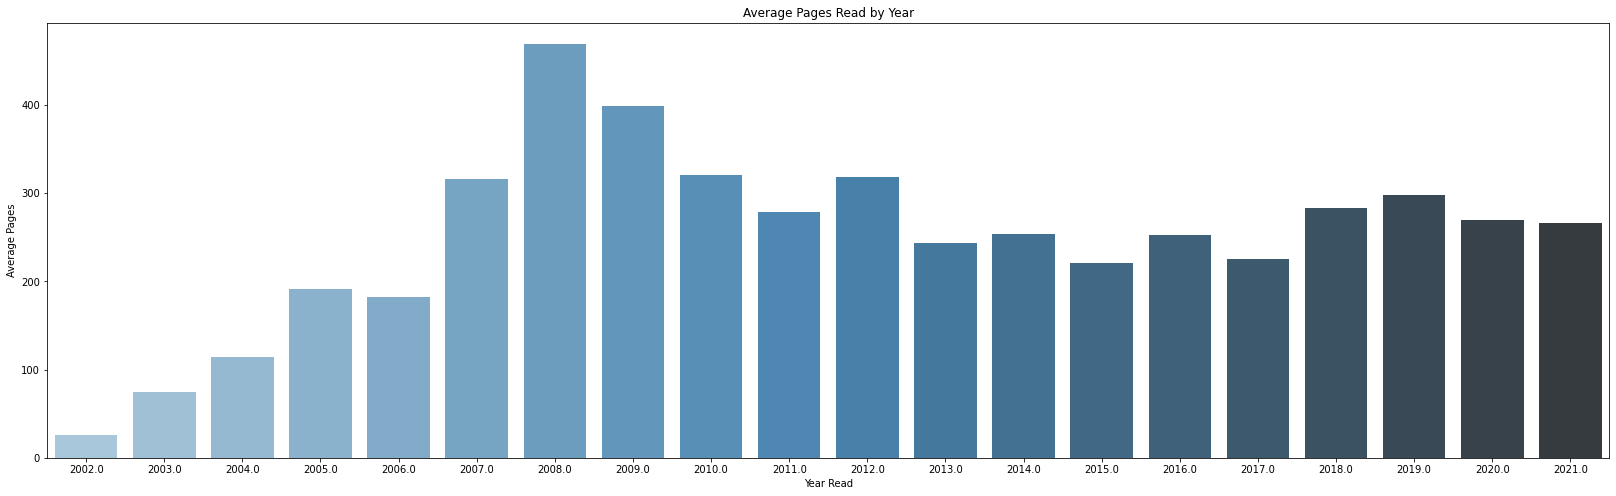

In [224]:
fig, ax = plt.subplots(figsize=(28,8))
plot = sns.barplot(x=pages_mean_df['Year Read'], y=pages_mean_df['Average Pages'], palette='Blues_d')
ax.set_title('Average Pages Read by Year')
plt.show()

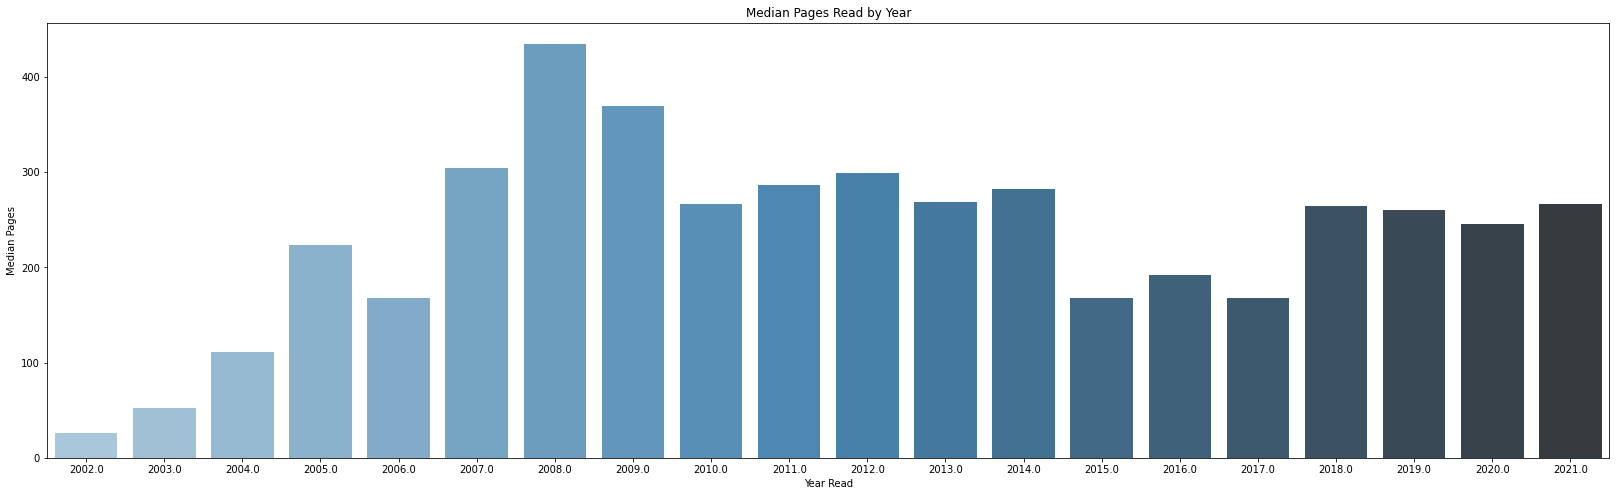

In [225]:
fig, ax = plt.subplots(figsize=(28,8))
plot = sns.barplot(x=pages_median_df['Year Read'], y=pages_median_df['Median Pages'], palette='Blues_d')
ax.set_title('Median Pages Read by Year')
plt.show()

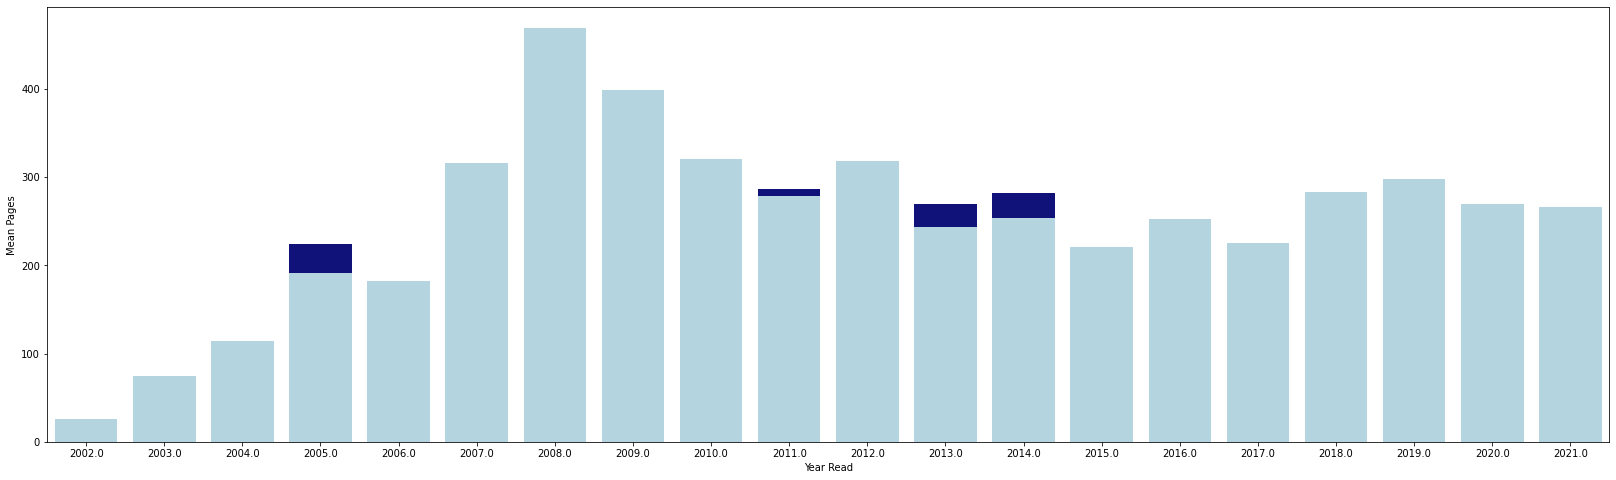

In [239]:
median_v_mean = pd.DataFrame({
    'Year Read': pages_median.index, 
    'Median Pages': pages_median.values, 
    'Mean Pages': pages_mean.values
})

plt.figure(figsize=(28, 8))
bar1 = sns.barplot(x=median_v_mean['Year Read'], y=median_v_mean['Median Pages'], color='darkblue')
bar2 = sns.barplot(x=median_v_mean['Year Read'], y=median_v_mean['Mean Pages'], estimator=sum, ci=None, color='lightblue')
top_bar = mpatches.Patch(color='darkblue', label='Median Pages')
bottom_bar = mpatches.Patch(color='lightblue', label='Mean Pages')
plot.legend(handles=[top_bar, bottom_bar])
plt.show()

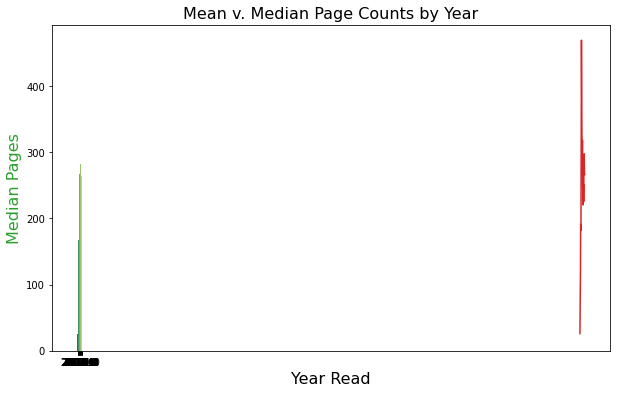

In [245]:
fig, ax1 = plt.subplots(figsize=(10,6))

color = 'tab:green'
ax1.set_title('Mean v. Median Page Counts by Year', fontsize=16)
ax1.set_xlabel('Year', fontsize=16)
ax1.set_ylabel('Page Count', fontsize=16, color=color)

ax2 = sns.barplot(x='Year Read', y='Median Pages', data = median_v_mean , palette='summer')
# ax1.tick_params(axis='y')
# ax2 = ax1.twinx()

color = 'tab:red'
# ax2.set_ylabel('Mean Pages', fontsize=16, color=color)
ax2 = sns.lineplot(x='Year Read', y='Mean Pages', data = median_v_mean, sort=False, color=color)
# ax2.tick_params(axis='y', color=color)
plt.show()

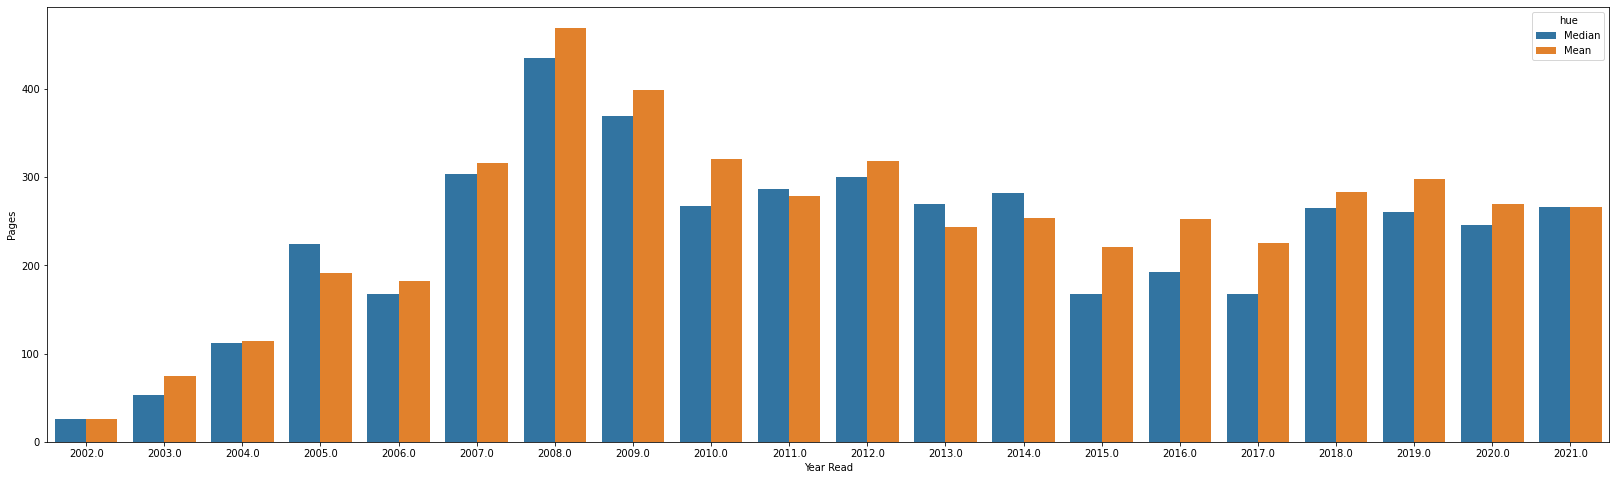

In [257]:
groupings = books_read.groupby(['Year Read'])
pages_mean = round(groupings['Number of Pages'].mean(),2)
pages_mean_df = pd.DataFrame({'Year Read': pages_mean.index, 'Pages': pages_mean.values})
pages_median = round(groupings['Number of Pages'].median(),2)
pages_median_df = pd.DataFrame({'Year Read': pages_median.index, 'Pages': pages_median.values})

fig, ax = plt.subplots(figsize=(28,8))

pages_median_df['hue'] = 'Median'
pages_mean_df['hue'] = 'Mean'

res = pd.concat([pages_median_df, pages_mean_df])
sns.barplot(data=res, x='Year Read', y='Pages', hue='hue')
plt.show()

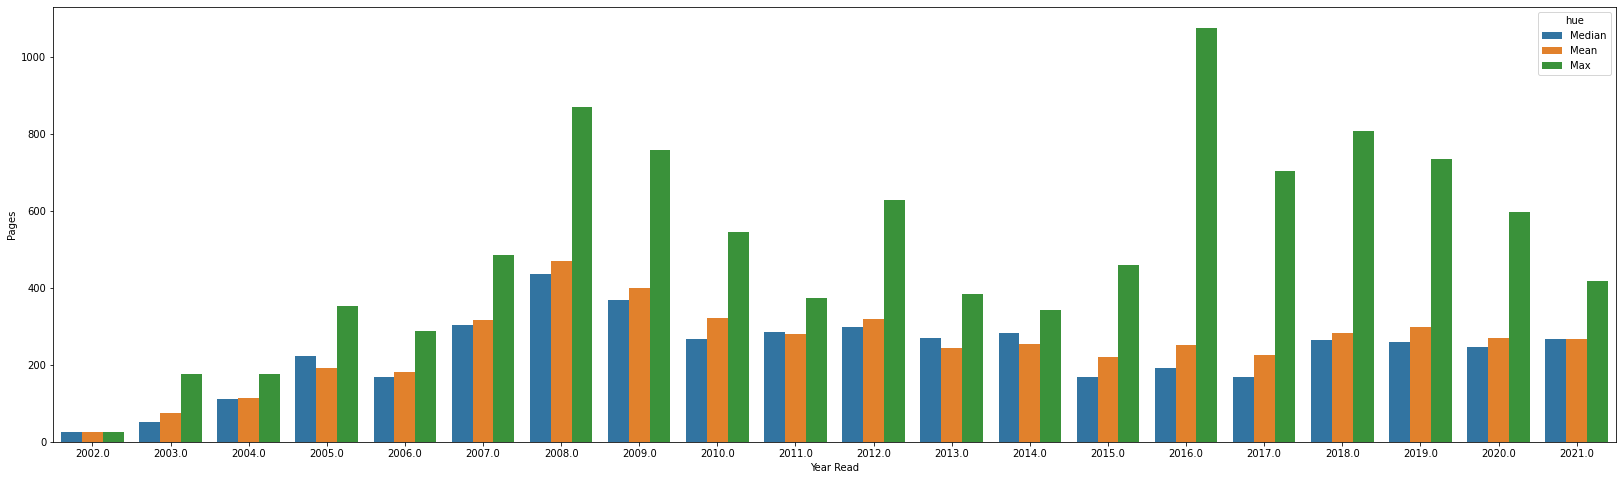

In [258]:
groupings = books_read.groupby(['Year Read'])

pages_mean = round(groupings['Number of Pages'].mean(),2)
pages_mean_df = pd.DataFrame({'Year Read': pages_mean.index, 'Pages': pages_mean.values})

pages_median = round(groupings['Number of Pages'].median(),2)
pages_median_df = pd.DataFrame({'Year Read': pages_median.index, 'Pages': pages_median.values})

pages_max = round(groupings['Number of Pages'].max(), 2)
pages_max_df = pd.DataFrame({'Year Read': pages_max.index, 'Pages': pages_max.values})

fig, ax = plt.subplots(figsize=(28,8))

pages_median_df['hue'] = 'Median'
pages_mean_df['hue'] = 'Mean'
pages_max_df['hue'] = 'Max'

res = pd.concat([pages_median_df, pages_mean_df, pages_max_df])
sns.barplot(data=res, x='Year Read', y='Pages', hue='hue')
plt.show()

In [290]:
instance = books_read.loc[books_read['Number of Pages'] == 759]
type(instance)

pandas.core.frame.DataFrame

In [311]:
pages_max = round(groupings['Number of Pages'].max(), 2)
pages_dict = pages_max.to_dict()
new_dict = {}
for key, val in pages_dict.items():
    match = books_read.loc[(books_read['Year Read'] == key) & (books_read['Number of Pages'] == val)]
    title_edits = match['Title'].to_string(index=False, dtype=False).strip()
    new_dict[key] = [title_edits, val]

print('Longest Reads by Year')
print('---------------------')
for key, val_list in new_dict.items():
    print("{}: {}, {} pages".format(key, val_list[0], val_list[1]))

Longest Reads by Year
---------------------


TypeError: 'float' object is not subscriptable

## Other Possible Directions

Author Read Counts
- Box Plot distributions for the pages of every individual book of the top 10 most read authors

Author Likability
- Average ratings and Number of Ratings
- Deviation from average rating based on my ratings
- Scatterplot of Avg. Rating v Number of Ratings

Count of Books Read by Month or Year
- Would be cool to be able to retrieve books read in a month across all years and explore trends.